### Full DnW Conversion ###

Converting both temperature to demand and wind speed to wind power generation, then taking the difference to calculate demand net wind. All in the same notebook.

Wind speed -> Wind power generation conversion first

In [1]:
%matplotlib inline

# Local imports
import os
import sys
import time
import argparse
import warnings

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.io.shapereader as shpreader
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

# Suppress warnings
warnings.filterwarnings('ignore')

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# Load my specific functions
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import plot_distributions_fidelity, plot_cdfs, \
    plot_qq, plot_rp_extremes, estimate_period, sigmoid, apply_detrend

In [3]:
# Set up the output directory for the dfs
output_dir_dfs = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

# Load the model data
df_model_sfcWind = pd.read_csv(f"{output_dir_dfs}/HadGEM3-GC31-MM_dcppA-hindcast_sfcWind_United_Kingdom_1960-2018_day.csv")

# set up the df obs sfcwing
df_obs_sfcWind = pd.read_csv("/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/ERA5_sfcWind_United_Kingdom_1960-2018_daily_2024-12-11.csv")

# load the clearheads data for wind generation
df_ch = pd.read_csv("/home/users/benhutch/unseen_multi_year/dfs/UK_clearheads_data_daily_1960_2018_ONDJFM.csv")

In [4]:
# Clean the obs data
df_obs_sfcWind["time"] = pd.to_datetime(df_obs_sfcWind["time"],
                                    origin='1952-01-01', unit='D')

# subset the data to O, N, D, J, F, M
df_obs_sfcWind = df_obs_sfcWind[
    df_obs_sfcWind['time'].dt.month.isin([10, 11, 12, 1, 2, 3])
]

In [5]:
# subset the model to the correct years
winter_years = np.arange(1, 10 + 1)

# set up a new df to append to
df_model_ondjfm= pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_sfcWind[df_model_sfcWind["lead"].isin(leads)]

    # include a new column

    # Append to the new df
    df_model_ondjfm = pd.concat([df_model_ondjfm, df_model_leads_this])

In [6]:
df_ch.head()

,date,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
0,1960-01-01,0.017302,7.625868,5.137020,47.696808,0.766016,0.298726,6.577980,7.835584,40.766836,41.666578,15.744187,25.022648,25.922391
1,1960-01-02,0.016300,4.930154,3.186221,44.535210,0.161353,0.101100,3.956466,5.214012,40.019199,43.863111,3.883881,36.135318,39.979230
2,1960-01-03,0.014511,7.249626,4.753627,39.765705,0.298246,0.266276,5.730921,6.988410,37.949476,42.640292,8.359369,29.590107,34.280923
3,1960-01-04,0.016632,9.558028,6.228839,46.044937,0.526643,0.363619,7.894082,9.151514,39.775870,40.584140,13.176714,26.599156,27.407426
4,1960-01-05,0.026247,8.874397,6.005377,71.949350,0.798906,0.376032,5.362875,6.620249,42.761398,42.761398,17.378747,25.382651,25.382651


In [7]:
df_obs_sfcWind.tail()

,time,data
21545,2018-12-27,2.477261
21546,2018-12-28,3.448565
21547,2018-12-29,5.573635
21548,2018-12-30,4.381348
21549,2018-12-31,5.464558


In [8]:
df_model_sfcWind.head()

,init_year,member,lead,data
0,1960,1,1,8.429288
1,1960,1,2,9.267500
2,1960,1,3,7.539931
3,1960,1,4,7.504783
4,1960,1,5,5.574239


In [9]:
# # Plot the distribution of 10m wind speed
# plot_distributions_fidelity(
#     obs_df=df_obs_sfcWind,
#     model_df=df_model_ondjfm,
#     obs_val_name="data",
#     model_val_name="data",
#     obs_time_name="time",
#     model_time_name="init_year",
#     model_member_name="member",
#     model_lead_name="lead",
#     title="Distribution ONDJFM UK 10m Wind Speed (GW)",
#     nboot=10,
#     figsize=(12, 6),
#     fname_prefix="UK_10m_wind_speed_ONDJFM_fidelity",
#     save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
# )

Now fit the sigmoid

In [10]:
# Set up an initial guess for the parameters based on the observed data
p0 = [max(df_ch["wind_gen"]), np.median(df_obs_sfcWind["data"]), 1, min(df_ch["wind_gen"])]

# Fit the sigmoid curve to the data
popt, pcov = curve_fit(sigmoid, df_obs_sfcWind["data"], df_ch["wind_gen"], p0=p0, method="dogbox")

Density range: 0.0 to 0.056535721756982675
Contour interval: 0.01884524058566089


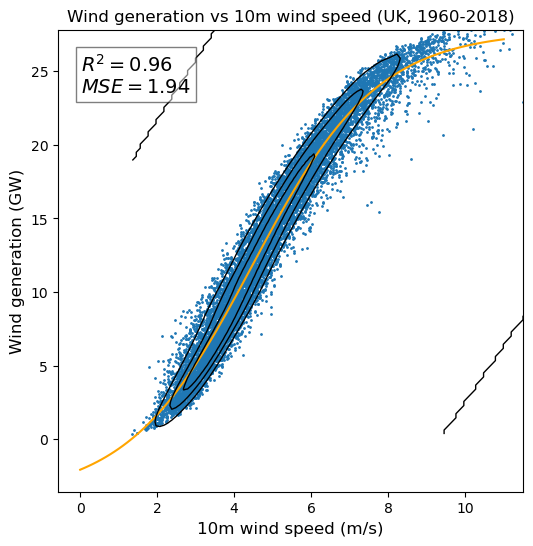

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score, mean_squared_error

# Assuming sigmoid and popt are already defined
# Define the sigmoid function if not already defined
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

# Set up a figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the scatter of the data
ax.scatter(df_obs_sfcWind['data'], df_ch['wind_gen'], s=1)

# Plot the sigmoid fit
x = np.linspace(0, round(max(df_obs_sfcWind['data'])), 100)
ax.plot(x, sigmoid(x, *popt), 'r-', label='fit: L=%5.3f, x0=%5.3f, k=%5.3f, b=%5.3f' % tuple(popt), color='orange')

# Calculate the density of the scatter points
xy = np.vstack([df_obs_sfcWind['data'], df_ch['wind_gen']])
z = gaussian_kde(xy)(xy)

# Create a grid of points where you want to evaluate the density
xmin, xmax = df_obs_sfcWind['data'].min(), df_obs_sfcWind['data'].max()
ymin, ymax = df_ch['wind_gen'].min(), df_ch['wind_gen'].max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
density = gaussian_kde(xy)(positions).reshape(xx.shape)

# Determine the range of density values
density_min = density.min()
density_max = density.max()

# # Number of contour levels
levels = 3

# # Calculate the contour interval
contour_interval = (density_max - density_min) / levels

# # we want the contour interval to be 0.02 %
# contour_interval = 0.02

# # configure the levels
# levels = (density_max - density_min) / contour_interval

# # print the levels
# print(f"Levels: {levels}")

print(f"Density range: {density_min} to {density_max}")
print(f"Contour interval: {contour_interval}")

# Plot the density contours
ax.contour(xx, yy, density, levels=levels, colors='black', linewidths=1)

# Calculate the R^2 value
r2 = r2_score(df_ch['wind_gen'], sigmoid(df_obs_sfcWind['data'], *popt))

# Calculate the mean squared error
mse = mean_squared_error(df_ch['wind_gen'], sigmoid(df_obs_sfcWind['data'], *popt))

# Include these values in a textbox in the top left
textstr = '\n'.join((
    r'$R^2=%.2f$' % (r2, ),
    r'$MSE=%.2f$' % (mse, )))

ax.text(
    0.05,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment='top',
    horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0.5)
)

# Set the labels
ax.set_xlabel('10m wind speed (m/s)', fontsize=12)
ax.set_ylabel('Wind generation (GW)', fontsize=12)

# Set the title
ax.set_title('Wind generation vs 10m wind speed (UK, 1960-2018)')

plt.show()

Fit looks good. Now we want to evaluate the performance of the converted model wind generation in terms of statistics.

In [12]:
# First create a column in the obs using the sigmoid function
df_obs_sfcWind["wind_gen_sigmoid"] = sigmoid(df_obs_sfcWind["data"], *popt)

Density range: 0.0 to 0.013703024744784043
Contour interval: 0.004567674914928014


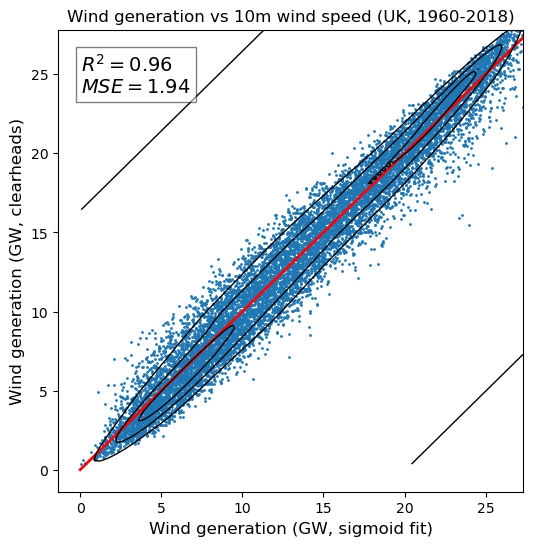

In [13]:
# Set up a figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the scatter of the data
ax.scatter(df_obs_sfcWind['wind_gen_sigmoid'], df_ch['wind_gen'], s=1)

# plot the 1:1 line as a solid black line
ax.plot([0, max(df_obs_sfcWind['wind_gen_sigmoid'])], [0, max(df_obs_sfcWind['wind_gen_sigmoid'])], color='red', linestyle='-', linewidth=2)

# Calculate the density of the scatter points
xy = np.vstack([df_obs_sfcWind['wind_gen_sigmoid'], df_ch['wind_gen']])
z = gaussian_kde(xy)(xy)

# Create a grid of points where you want to evaluate the density
xmin, xmax = df_obs_sfcWind['wind_gen_sigmoid'].min(), df_obs_sfcWind['wind_gen_sigmoid'].max()
ymin, ymax = df_ch['wind_gen'].min(), df_ch['wind_gen'].max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
density = gaussian_kde(xy)(positions).reshape(xx.shape)

# Determine the range of density values
density_min = density.min()
density_max = density.max()

# # Number of contour levels
levels = 3

# # Calculate the contour interval
contour_interval = (density_max - density_min) / levels

# # we want the contour interval to be 0.02 %
# contour_interval = 0.02

# # configure the levels
# levels = (density_max - density_min) / contour_interval

# # print the levels
# print(f"Levels: {levels}")

print(f"Density range: {density_min} to {density_max}")
print(f"Contour interval: {contour_interval}")

# Plot the density contours
ax.contour(xx, yy, density, levels=levels, colors='black', linewidths=1)

# Calculate the R^2 value
r2 = r2_score(df_ch['wind_gen'], df_obs_sfcWind['wind_gen_sigmoid'])

# Calculate the mean squared error
mse = mean_squared_error(df_ch['wind_gen'], df_obs_sfcWind['wind_gen_sigmoid'])

# Include these values in a textbox in the top left
textstr = '\n'.join((
    r'$R^2=%.2f$' % (r2, ),
    r'$MSE=%.2f$' % (mse, )))

ax.text(
    0.05,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment='top',
    horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0.5)
)

# Set the labels
ax.set_xlabel('Wind generation (GW, sigmoid fit)', fontsize=12)
ax.set_ylabel('Wind generation (GW, clearheads)', fontsize=12)

# Set the title
ax.set_title('Wind generation vs 10m wind speed (UK, 1960-2018)')

plt.show()

Sigmoid fit does a pretty good job of replicating the clearheads wind generation, albeit with +- 2/3 GW of uncertainty.

Now apply the same sigmoid fit to the model 10m wind speed data.

In [14]:
df_model_ondjfm_sfcWind = df_model_ondjfm.copy()

In [15]:
df_model_ondjfm_sfcWind["wind_gen_sigmoid"] = sigmoid(df_model_ondjfm_sfcWind["data"], *popt)

In [16]:
# # Compare the wind generation distribution from the model and the obs
# plot_distributions_fidelity(
#     obs_df=df_ch,
#     model_df=df_model_ondjfm,
#     obs_val_name="wind_gen", # CLEARHEADS ground-truth
#     model_val_name="wind_gen_sigmoid", # 10m wind speed sigmoid fit
#     obs_time_name="time",
#     model_time_name="init_year",
#     model_member_name="member",
#     model_lead_name="lead",
#     title="Distribution ONDJFM UK Wind Generation (GW)",
#     nboot=1000,
#     figsize=(12, 6),
#     fname_prefix="UK_wind_generation_ONDJFM_fidelity",
#     save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
# )

### Temperature -> demand ###

Do the conversion from temperature to demand.

In [17]:
# load the model data
df_model_tas = pd.read_csv(f"{output_dir_dfs}/HadGEM3-GC31-MM_dcppA-hindcast_tas_United_Kingdom_1960-2018_day.csv")

# subset the model to the correct years
winter_years = np.arange(1, 10 + 1)

# set up a new df to append to
df_model_ondjfm= pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_tas[df_model_tas["lead"].isin(leads)]

    # include a new column

    # Append to the new df
    df_model_ondjfm = pd.concat([df_model_ondjfm, df_model_leads_this])

# set up a new df to append to
df_model_ondjfm_wyear = pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_ondjfm[df_model_ondjfm["lead"].isin(leads)]

    # include a new column containing the winter year
    df_model_leads_this["winter_year"] = wyear

    # Append to the new df
    df_model_ondjfm_wyear = pd.concat([df_model_ondjfm_wyear, df_model_leads_this])

# add a new column for temp c in the model data
df_model_ondjfm_wyear['data_c'] = df_model_ondjfm_wyear['data'] - 273.15

# create a new column in df_model_ondjfm_wyear - effective_dec_year
df_model_ondjfm_wyear["effective_dec_year"] = df_model_ondjfm_wyear["init_year"] + df_model_ondjfm_wyear["winter_year"]

# load the obs data
df_obs_tas = pd.read_csv(f"{output_dir_dfs}/ERA5_tas_United_Kingdom_1960-2018_daily_2024-11-26.csv")

# Convert the 'time' column to datetime, assuming it represents days since "1950-01-01 00:00:00"
df_obs_tas['time'] = pd.to_datetime(df_obs_tas['time'], origin='1950-01-01', unit='D')

# subset the obs data to O, N, D, J, F, M
df_obs_tas = df_obs_tas[df_obs_tas['time'].dt.month.isin([10, 11, 12, 1, 2, 3])]

# new column for temp in C
df_obs_tas['data_c'] = df_obs_tas['data'] - 273.15

In [18]:
%%time

# Apply the detrend function to the data
df_obs_tas, df_model_tas = apply_detrend(
    obs_df=df_obs_tas,
    model_df=df_model_ondjfm_wyear,
    obs_val_name="data_c",
    model_val_name="data_c",
    obs_time_name="time",
    model_time_name="effective_dec_year",
    model_member_name="member",
    model_lead_name="lead",
)

The mean slope is 0.030071677811841058
The 2.5th percentile of the slopes is -0.013596000239910108
The 97.5th percentile of the slopes is 0.07067023285905695
The slope of the observations is 0.029431150102115586
The trend line obs is [4.0252645  4.0252645  4.0252645  ... 6.04006692 6.04006692 6.04006692]
The trend line model is [4.0252645  4.0252645  4.0252645  ... 6.04006692 6.04006692 6.04006692]
The trend final is 6.040066916249145
The trend final obs is 5.739350138130732
The model_val_name is data_c
The obs_val_name is data_c
The mean of the model data is 6.0440047854461305
The mean of the obs data is 6.083428703753268
CPU times: user 54.3 s, sys: 44.3 ms, total: 54.4 s
Wall time: 54.9 s


In [19]:
# # Validate the detrended temperature 
# plot_distributions_fidelity(
#     obs_df=df_obs_tas,
#     model_df=df_model_tas,
#     obs_val_name="data_c_dt",
#     model_val_name="data_c_dt",
#     obs_time_name="time",
#     model_time_name="init_year",
#     model_member_name="member",
#     model_lead_name="lead",
#     title="Distribution ONDJFM UK temperature (C) detrended",
#     nboot=1000,
#     figsize=(12, 6),
#     fname_prefix="UK_detr_temp_ONDJFM_fidelity",
#     save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
# )

Now convert to demand through HDD, CDD, and the regression relationships.

In [20]:
# Set up hdd and cdd
hdd_base = 15.5
cdd_base = 22.0

# Process the obs data
df_obs_tas['hdd_dt'] = df_obs_tas['data_c_dt'].apply(lambda x: max(0, hdd_base - x))
df_obs_tas['cdd_dt'] = df_obs_tas['data_c_dt'].apply(lambda x: max(0, x - cdd_base))

# process the model data
df_model_tas['hdd_dt'] = df_model_tas['data_c_dt'].apply(lambda x: max(0, hdd_base - x))
df_model_tas['cdd_dt'] = df_model_tas['data_c_dt'].apply(lambda x: max(0, x - cdd_base))

In [21]:
# Set up the path to the regression coeffs
regr_coeffs = "/home/users/benhutch/ERA5_energy_update/ERA5_Regression_coeffs_demand_model.csv"

# load the regression coeffs
df_regr = pd.read_csv(regr_coeffs)

# Set the index
df_regr.set_index("Unnamed: 0", inplace=True)

# Rename the columns by splitting by _ and extracting the second element
df_regr.columns = [x.split("_")[0] for x in df_regr.columns]

# if there is a column called "United" replace it with "United Kingdom"
if "United" in df_regr.columns:
    df_regr.rename(columns={"United": "United_Kingdom"}, inplace=True)

# extract the coeffs for the UK
time_coeff_uk = df_regr.loc["time", "United_Kingdom"]
hdd_coeff_uk = df_regr.loc["HDD", "United_Kingdom"]
cdd_coeff_uk = df_regr.loc["CDD", "United_Kingdom"]

# Calculate the obs demand detrended
df_obs_tas["UK_demand_dt"] = (
    (time_coeff_uk * 2017) + # demand year which the model is based on
    (hdd_coeff_uk * df_obs_tas["hdd_dt"]) +
    (cdd_coeff_uk * df_obs_tas["cdd_dt"])
)

# Calculate the model demand detrended
df_model_tas["UK_demand_dt"] = (
    (time_coeff_uk * 2017) + # demand year which the model is based on
    (hdd_coeff_uk * df_model_tas["hdd_dt"]) +
    (cdd_coeff_uk * df_model_tas["cdd_dt"])
)

In [22]:
# # Now validate the UK demand against the observed data
# plot_distributions_fidelity(
#     obs_df=df_obs_tas,
#     model_df=df_model_tas,
#     obs_val_name="UK_demand_dt",
#     model_val_name="UK_demand_dt",
#     obs_time_name="time",
#     model_time_name="init_year",
#     model_member_name="member",
#     model_lead_name="lead",
#     title="Distribution ONDJFM UK demand (GW) detrended",
#     nboot=1000,
#     figsize=(12, 6),
#     fname_prefix="UK_detr_demand_ONDJFM_fidelity",
#     save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
# )

### Demand net wind ###

Now merge the dataframes to look at the demand net wind.

In [23]:
# merge the obs data
df_obs = df_obs_sfcWind.merge(df_obs_tas, on="time", how="inner")

In [24]:
# rename data_x as "10m_wind_speed" and data_y as "temp_K"
df_obs.rename(columns={"data_x": "10m_wind_speed", "data_y": "temp_K"}, inplace=True)

In [25]:
df_model_ondjfm_sfcWind.head()

,init_year,member,lead,data,wind_gen_sigmoid
330,1960,1,331,4.469876,11.806168
331,1960,1,332,5.489894,16.641298
332,1960,1,333,6.172364,19.457478
333,1960,1,334,4.134217,10.172521
334,1960,1,335,4.603901,12.460984


In [26]:
df_model_ondjfm_sfcWind.rename(columns={"data": "10m_wind_speed"}, inplace=True)
df_model_tas.rename(columns={"data": "temp_K"}, inplace=True)

In [27]:
# Merge the model data on "init_year", "lead", and "member"
df_model = df_model_ondjfm_sfcWind.merge(df_model_tas, on=["init_year", "lead", "member"], how="inner")

In [30]:
df_ch.head()

,date,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
0,1960-01-01,0.017302,7.625868,5.137020,47.696808,0.766016,0.298726,6.577980,7.835584,40.766836,41.666578,15.744187,25.022648,25.922391
1,1960-01-02,0.016300,4.930154,3.186221,44.535210,0.161353,0.101100,3.956466,5.214012,40.019199,43.863111,3.883881,36.135318,39.979230
2,1960-01-03,0.014511,7.249626,4.753627,39.765705,0.298246,0.266276,5.730921,6.988410,37.949476,42.640292,8.359369,29.590107,34.280923
3,1960-01-04,0.016632,9.558028,6.228839,46.044937,0.526643,0.363619,7.894082,9.151514,39.775870,40.584140,13.176714,26.599156,27.407426
4,1960-01-05,0.026247,8.874397,6.005377,71.949350,0.798906,0.376032,5.362875,6.620249,42.761398,42.761398,17.378747,25.382651,25.382651


In [29]:
# Calculate the demand_dt_net_wind
df_model["demand_dt_net_wind"] = df_model["UK_demand_dt"] - df_model["wind_gen_sigmoid"]

In [31]:
# Calculate the demand_dt_net_wind for the obs
df_obs["demand_dt_net_wind"] = df_obs["UK_demand_dt"] - df_ch["wind_gen"]

Calculating bootstrap statistics: 100%|██████████| 1000/1000 [02:11<00:00,  7.61it/s]


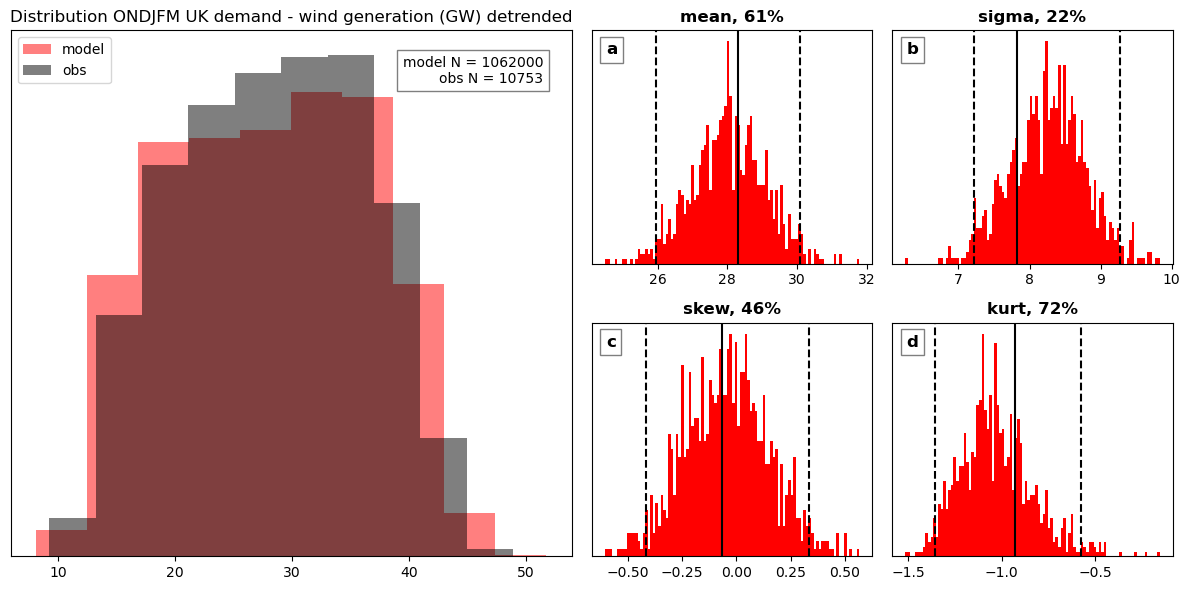

In [32]:
# Compare the demand_dt_net_wind distribution from the model and the obs
plot_distributions_fidelity(
    obs_df=df_obs,
    model_df=df_model,
    obs_val_name="demand_dt_net_wind", # Empirical demand - CH wind generation
    model_val_name="demand_dt_net_wind",
    obs_time_name="time",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name="lead",
    title="Distribution ONDJFM UK demand - wind generation (GW) detrended",
    nboot=1000,
    figsize=(12, 6),
    fname_prefix="UK_detr_demand_net_wind_ONDJFM_fidelity",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Looks pretty good! No bias correction needed either!!

Now do the conversion into the number of exceedance days for the winter to look at the overall severity.

In [34]:
# If time is a column for obs df
df_obs["time"] = pd.to_datetime(df_obs["time"])

# Set time as the index
df_obs.set_index("time", inplace=True)

In [35]:
df_obs.columns

Index(['10m_wind_speed', 'wind_gen_sigmoid', 'temp_K', 'data_c', 'data_c_dt',
       'hdd_dt', 'cdd_dt', 'UK_demand_dt', 'demand_dt_net_wind'],
      dtype='object')

In [36]:
df_ch.columns

Index(['date', 'solar_power', '100m_wind_speed', '10m_wind_speed',
       'solar_irradiance', 'ofs_cfs', 'ons_cfs', 't2m_no_detrend',
       't2m_2020_detrend', 'United_Kingdom_demand', 'United_Kingdom_wd_demand',
       'wind_gen', 'demand_net_wind', 'wd_demand_net_wind'],
      dtype='object')

In [37]:
df_ch["date"] = pd.to_datetime(df_ch["date"])

df_ch.set_index("date", inplace=True)

Plot the histograms of wind generation. To decide the obs threshold to use for wind drought days.

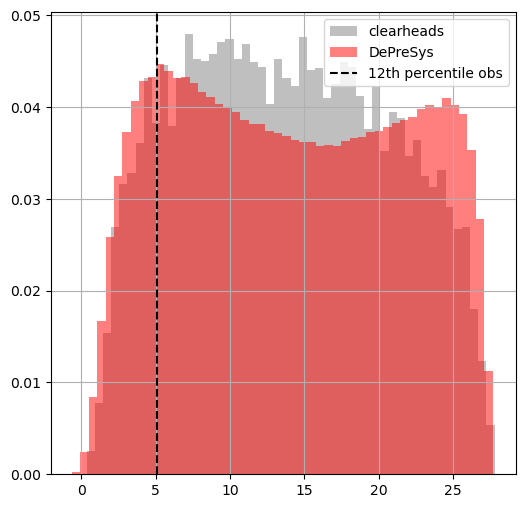

In [48]:
# set up a figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot a histogram of the wind generation clearheads
df_ch["wind_gen"].hist(bins=50, ax=ax, alpha=0.5, label="clearheads", color="gray", density=True)

# Plot a histogram of the wind generation obs
df_model["wind_gen_sigmoid"].hist(bins=50, ax=ax, alpha=0.5, label="DePreSys", color="red", density=True)

# plot a horizontal line for the 20th percentile of the obs
ax.axvline(df_ch["wind_gen"].quantile(0.12), color="black", linestyle="--", label="12th percentile obs")

# include a legend
ax.legend()

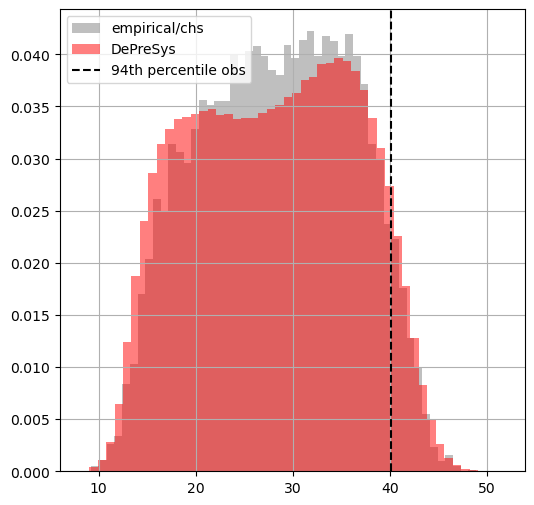

In [47]:
# Plot the distribution of the detrended demand - wind generation
fig, ax = plt.subplots(figsize=(6, 6))

# Plot a histogram of the demand net wind
df_obs["demand_dt_net_wind"].hist(bins=50, ax=ax, alpha=0.5, label="empirical/chs", color="gray", density=True)

# Plot a histogram of the demand net wind
df_model["demand_dt_net_wind"].hist(bins=50, ax=ax, alpha=0.5, label="DePreSys", color="red", density=True)

# plot a horizontal line for the 20th percentile of the obs
ax.axvline(df_obs["demand_dt_net_wind"].quantile(0.94), color="black", linestyle="--", label="94th percentile obs")

# include a legend in the top left
ax.legend(loc="upper left")

In [ ]:
# plot the demand
fig, ax = plt.subplots(figsize=(6, 6))

# Plot a histogram of the demand net wind
df_obs["UK_demand_dt"].hist(bins=50, ax=ax, alpha=0.5, label="empirical", color="gray", density=True)

# Plot a histogram of the demand net wind
df_model["UK_demand_dt"].hist(bins=50, ax=ax, alpha=0.5, label="DePreSys", color="red", density=True)

# plot a horizontal line for the 20th percentile of the obs
ax.axvline(df_obs["UK_demand_dt"].quantile(0.94), color="black", linestyle="--", label="94th percentile obs")

# include a legend in the top left


12th percentile of wind generation considered as ~5 GW of generation, which is very low/unusual during the winter. Can always test and adjust.

94th percentile of detrended demand net wind ~ 40 GW identified by Ben Sloman at NESO.

In [ ]:
# Therefore use the 92th percentile for exceedance
# loop over the winter years
winter_years = np.arange(1960, 2018 + 1)

# Set up an array to store the severity index
severity_index = np.zeros(len(winter_years))

# Set up an array to store the no. exceedance days
no_exceedance_days = np.zeros(len(winter_years))

# Set up an empty list for the dates
dates_exceedance_values_demand = []
severity_index_demand = []

# Same for wind speed
dates_undershoot_values_wind = []
severity_index_wind = []

# Same for demand net wind
dates_exceedance_values_demand_net_wind = []
severity_index_demand_net_wind = []

# 92 just chosen to be in line with demand net wind
all_winters_92_demand = np.percentile(df_obs["UK_demand"], 92)

# 92nd percentile for demand net wind, based on NESO guidance ~42 GW?


# loop over the winter years
for i, year in enumerate(winter_years):
    # Set up the first and last day of the winter
    winter_start = pd.Timestamp(f"{year}-10-01")
    winter_end = pd.Timestamp(f"{year+1}-03-31")

    # subset the data
    df = df_obs.loc[winter_start:winter_end]

    # if df includes 29th feb, then drop this row
    if f"{year + 1}-02-29" in df.index:
        print("Dropping 29th Feb")
        df = df.drop(pd.Timestamp(f"{year + 1}-02-29"))

    # apply a boolean mask to the demand net wind value
    # which is true where the demand net wind is greater than the 80% tile value
    mask = df["UK_demand"] > all_winters_92

    # # plot the data as a grey line
    # ax.plot(index_date, df["UK_demand"], color="grey", alpha=0.2)

    # # plot the masked values as red dots
    # ax.plot(index_date[mask], df["UK_demand"][mask], "rx")

    # calculate the severity index
    severity_index[i] = (df["UK_demand"][mask] - all_winters_92).sum()

    # calculate the no. exceedance days
    no_exceedance_days[i] = mask.sum()

    # calculate the mean demand net wind for the winter
    winter_mean_dnw.append(df["UK_demand"].mean())

    # format the dates to yyyy-mm-dd
    dates = df.index[mask].strftime("%Y-%m-%d")

    # Add the dates and values to the list
    dates_exceedance_values.extend(df.index[mask])

    # Add the exceedance values to the list
    exceedance_values.extend(df["UK_demand"][mask])

# set up a dataframe for the number of exceedance days
df_exceedance_days_obs = pd.DataFrame(
    {
        "severity": severity_index,
        "no_exceedance_days": no_exceedance_days,
        "winter_mean_dnw": winter_mean_dnw,
    },
    index=winter_years,
)